# Hyperparameter tuning for decision trees

We have now found that a decision tree, inspired by the iMeta algorithm, gives good results with the XBT dataset, and that the results hold up well using cross-validation, which shows that the initial results were not an artifact of the particular choice of split. The next step is to consider the hyperparameters of this algorithm. This affects whether the algorithm has a tendency to overfit or underfit. The optimal values for the hyperparameters tend to be problem dependent, so need to be tuned for each problem.

Hyperparameter tuning trains the algorithm with different set of hyperparameter values, evaluates accruacy for erach and compares results to find the best hyperparameter combination for this problem.

### Set up tools
Start by importing libraries and specifying the parameters for the experiment.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import pathlib

In [2]:
import ipywidgets
import time

In [3]:
import pandas
import numpy
import matplotlib
import matplotlib.pyplot

In [4]:
import sklearn
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.tree
import sklearn.metrics

In [5]:
root_repo_dir = pathlib.Path().absolute().parent
sys.path = [os.path.join(root_repo_dir)] + sys.path

In [6]:
import dataexploration.xbt_dataset
from dataexploration.xbt_dataset import XbtDataset, UNKNOWN_STR, cat_output_formatter, check_value_found

In [7]:
from imeta import imeta_classification, XBT_MAX_DEPTH

In [8]:
# Set up some site specific parameters for the notebook
try:
    environment = os.environ['XBT_ENV_NAME']
except KeyError:
    environment = 'pangeo'

In [9]:
root_data_dirs = {
    'MO_scitools': '/data/users/shaddad/xbt-data/',
    'pangeo': '/data/misc/xbt-data/',
}
env_date_ranges = {
    'MO_scitools': (1966,2015),
    'pangeo': (1966,2015)
}

### Define experiment parameters
These are some key hyperparameters we're using for this experiment, such as input features and number of splits. These are hyperparameters that are no problem specific and are not part of the tuning process.

In [10]:
experiment_name = 'nb_decisionTree_cv_country'
suffix='country'
cv_metrics = ['recall_micro', 'precision_micro', 'f1_micro']
hp_tune_metric = 'recall_micro'

In [11]:
input_feature_names = ['country','max_depth', 'year']
target_feature = 'instrument'
splitter_features = ['year', 'instrument']
unseen_feature = 'cruise_number'
ensemble_unseen_fraction = 0.1
num_unseen_splits = 5
unseen_fraction = 1.0 / num_unseen_splits
num_train_splits = 5
train_fraction = 1.0 - (1.0 / num_train_splits)
unseen_fold_name = 'unseen_fold'

here we define which classification algorithm we are using (a decision tree), and then we define the hyperparameter combination to be used in tuning. We are using grid search, so the tuner will create a list of all possible combination of the values of the three hyperparameters and try each to get the best result. The three hyperparameters we are tuning here are:
* `max_depth` -  controls how deep the tree can get. The deeper the tree, the more complex decision function that can be created but the greater the danger of overfitting and poor generalisation. `None` in this case means the tree has no depth limit.
  * *NOTE: this is the depth of the decision tree, not the temperature probe in this case!!*
* `min_samples_leaf` trhis controls how the leaf nodes of the tree are split to model more complex decisions. Like with max depth, the morereadily the tree splits, the complex the decision can be, but the greater the danger of overfitting.
* `criterion` - the loss function used in training the tree

In [ ]:
classifier_class = sklearn.tree.DecisionTreeClassifier
classifier_opts = {}
classifier_name = 'decision_tree_cv'

In [ ]:
classifier_param_grid = {
    'max_depth': [None, 1,5,10,20], 
    'min_samples_leaf': [1,2,5], 
    'criterion': ['gini', 'entropy']
},


In [12]:
# Set up some dataset specific parameters
root_data_dir = root_data_dirs[environment]
year_range = env_date_ranges[environment]

In [13]:
input_dir_name = 'csv_with_imeta'
exp_out_dir_name = 'experiment_outputs'

In [14]:
xbt_input_dir = os.path.join(root_data_dir, input_dir_name)
xbt_output_dir = os.path.join(root_data_dir, exp_out_dir_name, experiment_name)

In [15]:
# create the output for this experiment if it doesn't exist
if not os.path.isdir(xbt_output_dir):
    os.makedirs(xbt_output_dir)
print(f'outputting to {xbt_output_dir}')

outputting to /data/misc/xbt-data/experiment_outputs/nb_decisionTree_cv_country


In [16]:
output_fname_template = 'xbt_output_{classifier}_{suffix}.csv'
result_fname_template = 'xbt_metrics_{classifier}_{suffix}.csv'

## Running the cross validation experiment

In this experiment we will be combining hyperparameter tuning with cross-validation. There are multiple levels to the experiment we want to run. The first to train on part of the data and then test on another part. We want to divide up the profiles by cruise, so the test data consists of cruises that were not seen in the training data. We then want to train a model for each of the possible train/test splits. We divide the model into "folds", and then each splits uses data in fold n as the test set and ther rest as the train, as is standard in machine learning. In this case calculate the fold labels manually rather than using standard functions so we can divide based on cruise number and assign profiles to a fold based on which cruise they come from.

For the training on eeach split, we also then want to use the best hyperparameters. So for each split we run a hyperparameter tuning scheme, in this case a grid search through the request values of the hyper parameters, decribed previously.

The bottom level is that for each split and set of hyperparameters, we also want to run cross valdation within that training set, to check we have robust results. So we haveter and inner cross validation run together with hper parameter tuning to ensure we have robust results that are as good as we can get, and that demonstrate how well the trainined algorithm will generalise to the unlabelled data.

More information on the approach taken here and the spceific classes and function used can found in the following links:

scikit-learn API documentation:
* https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier
* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html
* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html
* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

discussion of cross-validationand hyperparameters for decision trees:
* https://scikit-learn.org/stable/modules/cross_validation.html
* https://stackoverflow.com/questions/60996995/use-groupkfold-in-nested-cross-validation-using-sklearn
* https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html
* https://scikit-learn.org/stable/modules/tree.html


In [17]:
%%time
xbt_full_dataset = XbtDataset(xbt_input_dir, year_range)

CPU times: user 1min 34s, sys: 9.29 s, total: 1min 43s
Wall time: 5min 55s


In [18]:
%%time
xbt_labelled = xbt_full_dataset.filter_obs({'labelled': 'labelled'})

CPU times: user 601 ms, sys: 36.2 ms, total: 637 ms
Wall time: 634 ms


In [19]:
_ = xbt_labelled.get_ml_dataset(return_data=False)

In [20]:
_ = xbt_labelled.filter_features(dataexploration.xbt_dataset.TARGET_FEATURES).encode_target(return_data = False)

### Outer split for ensemble testing
As part of this experiment, we will be combining the classifiers on trained each of the splits by using the output of each as avote, and then calculating a pseudo-probability based on the voting. In order to compare the performance of the ensemble voting classifier results with individual classifiers, we need some data that has not been used to train the ensemble. Each individual classifier created excludes a fold of the data for testing by default as part of cross-validation, which is good ML practice. But when all the classifiers are combined, the ensemble has been trained on all the data presented to the cross-validation algorithm, so we need a separate test set for evaluating the metrics of the ensemble classifier. So as for inside cross-validation, we will select some cruises which we hold back and then use at the end for evaluation.

In [21]:
# ensemble_unseen_cruise_numbers = xbt_labelled.sample_feature_values(unseen_feature, fraction=ensemble_unseen_fraction, split_feature='year')    
ensemble_unseen_cruise_numbers = xbt_labelled.sample_feature_values(unseen_feature, fraction=ensemble_unseen_fraction)    
xbt_ens_unseen = xbt_labelled.filter_obs({unseen_feature: ensemble_unseen_cruise_numbers}, mode='include', check_type='in_filter_set')
xbt_ens_working = xbt_labelled.filter_obs({unseen_feature: ensemble_unseen_cruise_numbers}, mode='exclude', check_type='in_filter_set')

In [22]:
%%time
xbt_ens_working.generate_folds_by_feature('cruise_number', num_unseen_splits, unseen_fold_name)

CPU times: user 33.3 s, sys: 76.8 ms, total: 33.4 s
Wall time: 33.4 s


In [23]:
X_labelled = xbt_ens_working.filter_features(input_feature_names).get_ml_dataset()[0]
y_labelled = xbt_ens_working.filter_features([target_feature]).get_ml_dataset()[0]


In [24]:
group_cv1 = sklearn.model_selection.GroupKFold(n_splits=num_unseen_splits)

In [25]:

clf_dt1 = classifier_class(**classifier_opts)
clf_gridcv1 = sklearn.model_selection.GridSearchCV(clf_dt1,
                                                   param_grid = classifier_param_grid,                                          
                                                   scoring=hp_tune_metric,
                                                   cv=num_train_splits,
                                                  )

In [26]:
%%time
scores = sklearn.model_selection.cross_validate(
    clf_gridcv1,
    X_labelled, y_labelled, 
    groups=xbt_ens_working[unseen_fold_name], 
    cv=group_cv1,
    return_estimator=True,
    return_train_score=True,
    scoring=cv_metrics,
    n_jobs=-1,
)

CPU times: user 356 ms, sys: 524 ms, total: 879 ms
Wall time: 15min 19s


## Generate probabilities and evaluate

In the outer cross-validation, we trained one classifier for each split. Ultimately we need to choose one set of predictions, which one is best? Instead of picking one, we are creating a voting based ensemble classifier, rather than just retraining on all of the data. To create this, we sue the prediction from each classifier and for each profile, consider the output of a classifier as a vote, and find which instrument type gets the most votes. We can specify this as a pseudo probability by dividing the number of votes for each instrument type by the total number of votes (i.e. the total number of classifiers). The instrument type with maximum probabilty is the classification chosen, but this also gives some idea of uncertainty, as where the classifiers disagree, we know we are less certain about the result.

In [27]:
result_feature_template = 'instrument_res_dt_split{split_num}'

In [28]:
%%time
res_ens_working = {'id': xbt_ens_working.xbt_df['id']}
res_ens_unseen = {'id': xbt_ens_unseen.xbt_df['id']}
vote_count_working = numpy.zeros([xbt_ens_working.shape[0], xbt_labelled._feature_encoders[target_feature].classes_.shape[0]],dtype=numpy.float64)
vote_count_unseen = numpy.zeros([xbt_ens_unseen.shape[0], xbt_labelled._feature_encoders[target_feature].classes_.shape[0]],dtype=numpy.float64)
result_feature_names = []
# classifications_df = None
for split_num, estimator in enumerate(scores['estimator']):
    res_name = result_feature_template.format(split_num=split_num)
    result_feature_names += [res_name]
    res_ml1_working = estimator.predict(xbt_ens_working.filter_features(input_feature_names).get_ml_dataset()[0])
    res2_working = xbt_ens_working._feature_encoders[target_feature].inverse_transform(res_ml1_working).reshape(-1,1)
    res_ens_working[res_name] = res2_working.reshape(-1)
    vote_count_working += xbt_ens_working._target_encoders[target_feature].transform(res2_working)
    
    res_ml1_unseen = estimator.predict(xbt_ens_unseen.filter_features(input_feature_names).get_ml_dataset()[0])
    res2_unseen = xbt_ens_unseen._feature_encoders[target_feature].inverse_transform(res_ml1_unseen).reshape(-1,1)
    res_ens_unseen[res_name] = res2_unseen.reshape(-1)
    vote_count_unseen += xbt_ens_unseen._target_encoders[target_feature].transform(res2_unseen)
    
df_ens_working = pandas.DataFrame(res_ens_working)
df_ens_unseen = pandas.DataFrame(res_ens_unseen)

vote_count_working /= float(len(res_ens_working.keys()))    
vote_count_unseen /= float(len(res_ens_working.keys()))    


CPU times: user 5.05 s, sys: 1.78 s, total: 6.83 s
Wall time: 6.83 s


In [29]:
max_prob_feature_name = f'{target_feature}_max_prob'
res_working_ensemble = vote_count_working.argmax(axis=1)
instr_res_working_ensemble = xbt_labelled._feature_encoders[target_feature].inverse_transform(res_working_ensemble)
df_ens_working[max_prob_feature_name] = instr_res_working_ensemble
res_unseen_ensemble = vote_count_unseen.argmax(axis=1)
instr_res_unseen_ensemble = xbt_labelled._feature_encoders[target_feature].inverse_transform(res_unseen_ensemble)
df_ens_unseen[max_prob_feature_name] = instr_res_unseen_ensemble

In [30]:
df_ens_working = pandas.merge(df_ens_working, xbt_ens_working.xbt_df[['id', 'year']])
df_ens_unseen = pandas.merge(df_ens_unseen, xbt_ens_unseen.xbt_df[['id', 'year']])

In [31]:
metric_list_ens = []
for year in range(year_range[0],year_range[1]):
    y_ens_working = xbt_ens_working.filter_obs({'year': year} ).filter_features([target_feature]).get_ml_dataset()[0]
    y_ens_unseen = xbt_ens_unseen.filter_obs({'year': year} ).filter_features([target_feature]).get_ml_dataset()[0]


    y_res_working = xbt_ens_working._feature_encoders[target_feature].transform( df_ens_working[df_ens_working.year == year]['instrument_max_prob'])    
    y_res_unseen = xbt_ens_unseen._feature_encoders[target_feature].transform( df_ens_unseen[df_ens_unseen.year == year]['instrument_max_prob'])    
    cats = list(xbt_ens_working._feature_encoders[target_feature].classes_)
    prec_ens_working, recall_ens_working, f1_ens_working, support_ens_working = sklearn.metrics.precision_recall_fscore_support(
        y_ens_working, y_res_working, average='micro', labels=range(0,len(cats)))
    prec_ens_unseen, recall_ens_unseen, f1_ens_unseen, support_ens_unseen = sklearn.metrics.precision_recall_fscore_support(
        y_ens_unseen, y_res_unseen, average='micro', labels=range(0,len(cats)))

    column_template = '{metric}_{data}_{subset}'
    metric_dict = {'year': year,
                   column_template.format(data='ens_working', metric='precision', subset='all'): prec_ens_working,
                   column_template.format(data='ens_working', metric='recall', subset='all'): recall_ens_working,
                   column_template.format(data='ens_working', metric='f1', subset='all'): f1_ens_working,
                   column_template.format(data='ens_unseen', metric='precision', subset='all'): prec_ens_unseen,
                   column_template.format(data='ens_unseen', metric='recall', subset='all'): recall_ens_unseen,
                   column_template.format(data='ens_unseen', metric='f1', subset='all'): f1_ens_unseen,
                  }

    metric_list_ens += [metric_dict]
metrics_df_ens = pandas.DataFrame.from_records(metric_list_ens)    

In [32]:
cats = list(xbt_ens_working._feature_encoders[target_feature].classes_)

In [33]:
y_ens_working = xbt_ens_working.filter_features([target_feature]).get_ml_dataset()[0]
y_res_working = xbt_ens_working._feature_encoders[target_feature].transform( df_ens_working['instrument_max_prob'])    
prec_ens_working, recall_ens_working, f1_ens_working, support_ens_working = sklearn.metrics.precision_recall_fscore_support(
    y_ens_working, y_res_working, average='micro', labels=range(0,len(cats)))

column_template = '{metric}_{data}_{subset}'
scores_ens_working = {
    'name': 'ens_working',
    'subset': 'train',
    'precision_all': prec_ens_working,
    'recall_all': recall_ens_working,
    'f1_all': f1_ens_working,
    'support_all': support_ens_working,
}


In [34]:
y_ens_unseen = xbt_ens_unseen.filter_features([target_feature]).get_ml_dataset()[0]
y_res_unseen = xbt_ens_unseen._feature_encoders[target_feature].transform( df_ens_unseen['instrument_max_prob'])    
prec_ens_unseen, recall_ens_unseen, f1_ens_unseen, support_ens_unseen = sklearn.metrics.precision_recall_fscore_support(
    y_ens_unseen, y_res_unseen, average='micro', labels=range(0,len(cats)))
scores_ens_unseen = {
    'name': 'ens_unseen',
    'subset': 'unseen',
    'precision_all': prec_ens_unseen,
    'recall_all': recall_ens_unseen,
    'f1_all': f1_ens_unseen,
    'support_all': f1_ens_unseen,
}

In [35]:
count_working = df_ens_working[result_feature_names].apply(lambda row1: len(set(row1.values)), axis='columns')
count_working.value_counts()

1    690968
2    333011
3      6246
4       653
dtype: int64

In [36]:
count_unseen = df_ens_unseen[result_feature_names].apply(lambda row1: len(set(row1.values)), axis='columns')
count_unseen.value_counts()

1    74431
2    33168
3      572
4       31
dtype: int64

## Plotting results of cross-validation and hyperparameter tuning
In this section we will take a look at the results from the cross validation and hyperparameter tuning of the decision tree to the XBT labelled data. To gain greater understanding, we seprately score the train and test sets for each year of the data and each class of instrument label. This is calculated separately for eeach of the estimators trained for the outer cross-validation (based on cruise numbers). We calculate the recall, precision and f1 metrics both for each class and averaged over all classes.

In [37]:
def generate_metrics(clf, xbt_ds, data_label, target_feature, input_feature_names, year_range, subset):
    metric_list = []
    for year in range(year_range[0],year_range[1]):
        X_year = xbt_ds.filter_obs({'year': year}, ).filter_features(input_feature_names).get_ml_dataset()[0]
        y_year = xbt_ds.filter_obs({'year': year} ).filter_features([target_feature]).get_ml_dataset()[0]

        y_res_year = clf.predict(X_year)
        cats = list(xbt_ds._feature_encoders[target_feature].classes_)
        prec_year, recall_year, f1_year, support_year = sklearn.metrics.precision_recall_fscore_support(
            y_year, y_res_year, average='micro', labels=range(0,len(cats)))
        prec_cat, recall_cat, f1_cat, support_cat = sklearn.metrics.precision_recall_fscore_support(
            y_year, y_res_year, labels=range(0,len(cats)))

        column_template = '{metric}_{data}_{subset}'
        metric_dict = {'year': year,
                       column_template.format(data=data_label, metric='precision', subset='all'): prec_year,
                       column_template.format(data=data_label, metric='recall', subset='all'): recall_year,
                       column_template.format(data=data_label, metric='f1', subset='all'): f1_year,
                      }

        metric_dict.update({column_template.format(data=data_label, metric='precision', subset=cat): val for cat, val in zip(cats, prec_cat)})
        metric_dict.update({column_template.format(data=data_label, metric='recall', subset=cat): val for cat, val in zip(cats, recall_cat)})
        metric_dict.update({column_template.format(data=data_label, metric='f1', subset=cat): val for cat, val in zip(cats, f1_cat)})
        metric_dict.update({column_template.format(data=data_label, metric='support', subset=cat): val for cat, val in zip(cats, support_cat)})
        metric_list += [metric_dict]

    metrics_df = pandas.DataFrame.from_records(metric_list)
    
    X_full = xbt_ds.filter_features(input_feature_names).get_ml_dataset()[0]
    y_full = xbt_ds.filter_features([target_feature]).get_ml_dataset()[0]
    y_res_full = clf.predict(X_full)
    prec_full, recall_full, f1_full, support_full = sklearn.metrics.precision_recall_fscore_support(
            y_full, y_res_full, average='micro')
    metrics_full = {
        'name': data_label,
        'subset': subset,
        'precision_all': prec_full,
        'recall_all': recall_full,
        'f1_all': f1_full,
        'support_all': support_full,
        }    
    return metrics_df, metrics_full

In [40]:
%%time
metrics_list = {}
scores_list = [scores_ens_working, scores_ens_unseen]
for split_num, estimator in enumerate(scores['estimator']):
    xbt_train = xbt_ens_working.filter_obs({unseen_fold_name: split_num}, mode='exclude')
    xbt_test = xbt_ens_working.filter_obs({unseen_fold_name: split_num}, mode='include')
    train_metrics, train_scores = generate_metrics(estimator, xbt_train, 'train_{0}'.format(split_num), target_feature, input_feature_names, year_range, 'train' )
    test_metrics, test_scores = generate_metrics(estimator, xbt_test, 'test_{0}'.format(split_num), target_feature, input_feature_names, year_range, 'test')
    unseen_metrics, unseen_scores = generate_metrics(estimator, xbt_ens_unseen, 'unseen_{0}'.format(split_num), target_feature, input_feature_names, year_range, 'unseen')
    scores_list += [train_scores, test_scores, unseen_scores]
    metrics_list[split_num] = pandas.merge(pandas.merge(train_metrics, test_metrics, on='year'), unseen_metrics, on='year')
scores_df = pandas.DataFrame.from_records(scores_list)

CPU times: user 48.5 s, sys: 9.87 s, total: 58.4 s
Wall time: 58.4 s


In [41]:
scores_df[scores_df.subset == 'unseen']

,name,subset,precision_all,recall_all,f1_all,support_all
1,ens_unseen,unseen,0.853829,0.853829,0.853829,0.853829
4,unseen_0,unseen,0.696022,0.696022,0.696022,NaN
7,unseen_1,unseen,0.855594,0.855594,0.855594,NaN
10,unseen_2,unseen,0.835761,0.835761,0.835761,NaN
13,unseen_3,unseen,0.850751,0.850751,0.850751,NaN
16,unseen_4,unseen,0.856130,0.856130,0.856130,NaN


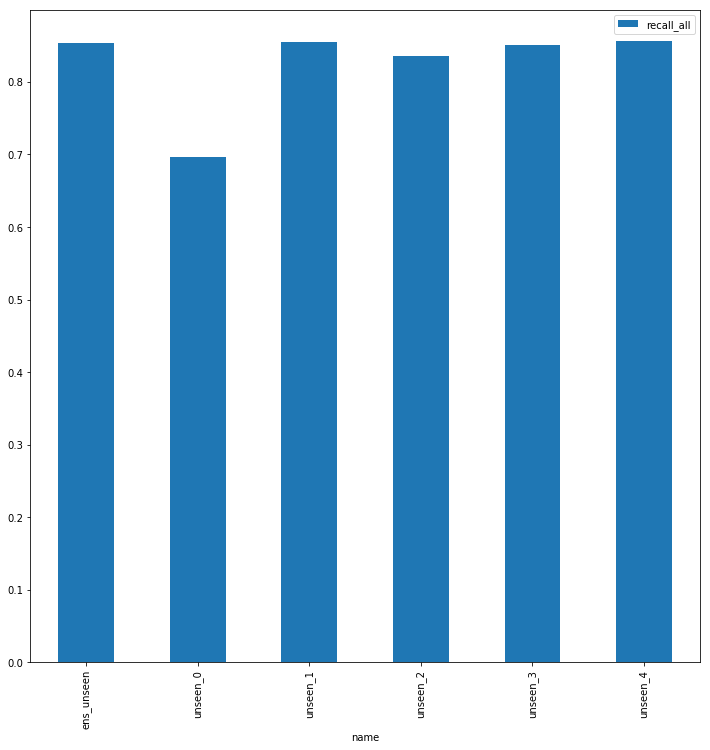

In [42]:
scores_df[scores_df.subset == 'unseen'].plot.bar(x='name',y='recall_all',figsize=(12,12))

We see that the recall of the ensemble generally matches the best value of any individual classifier.

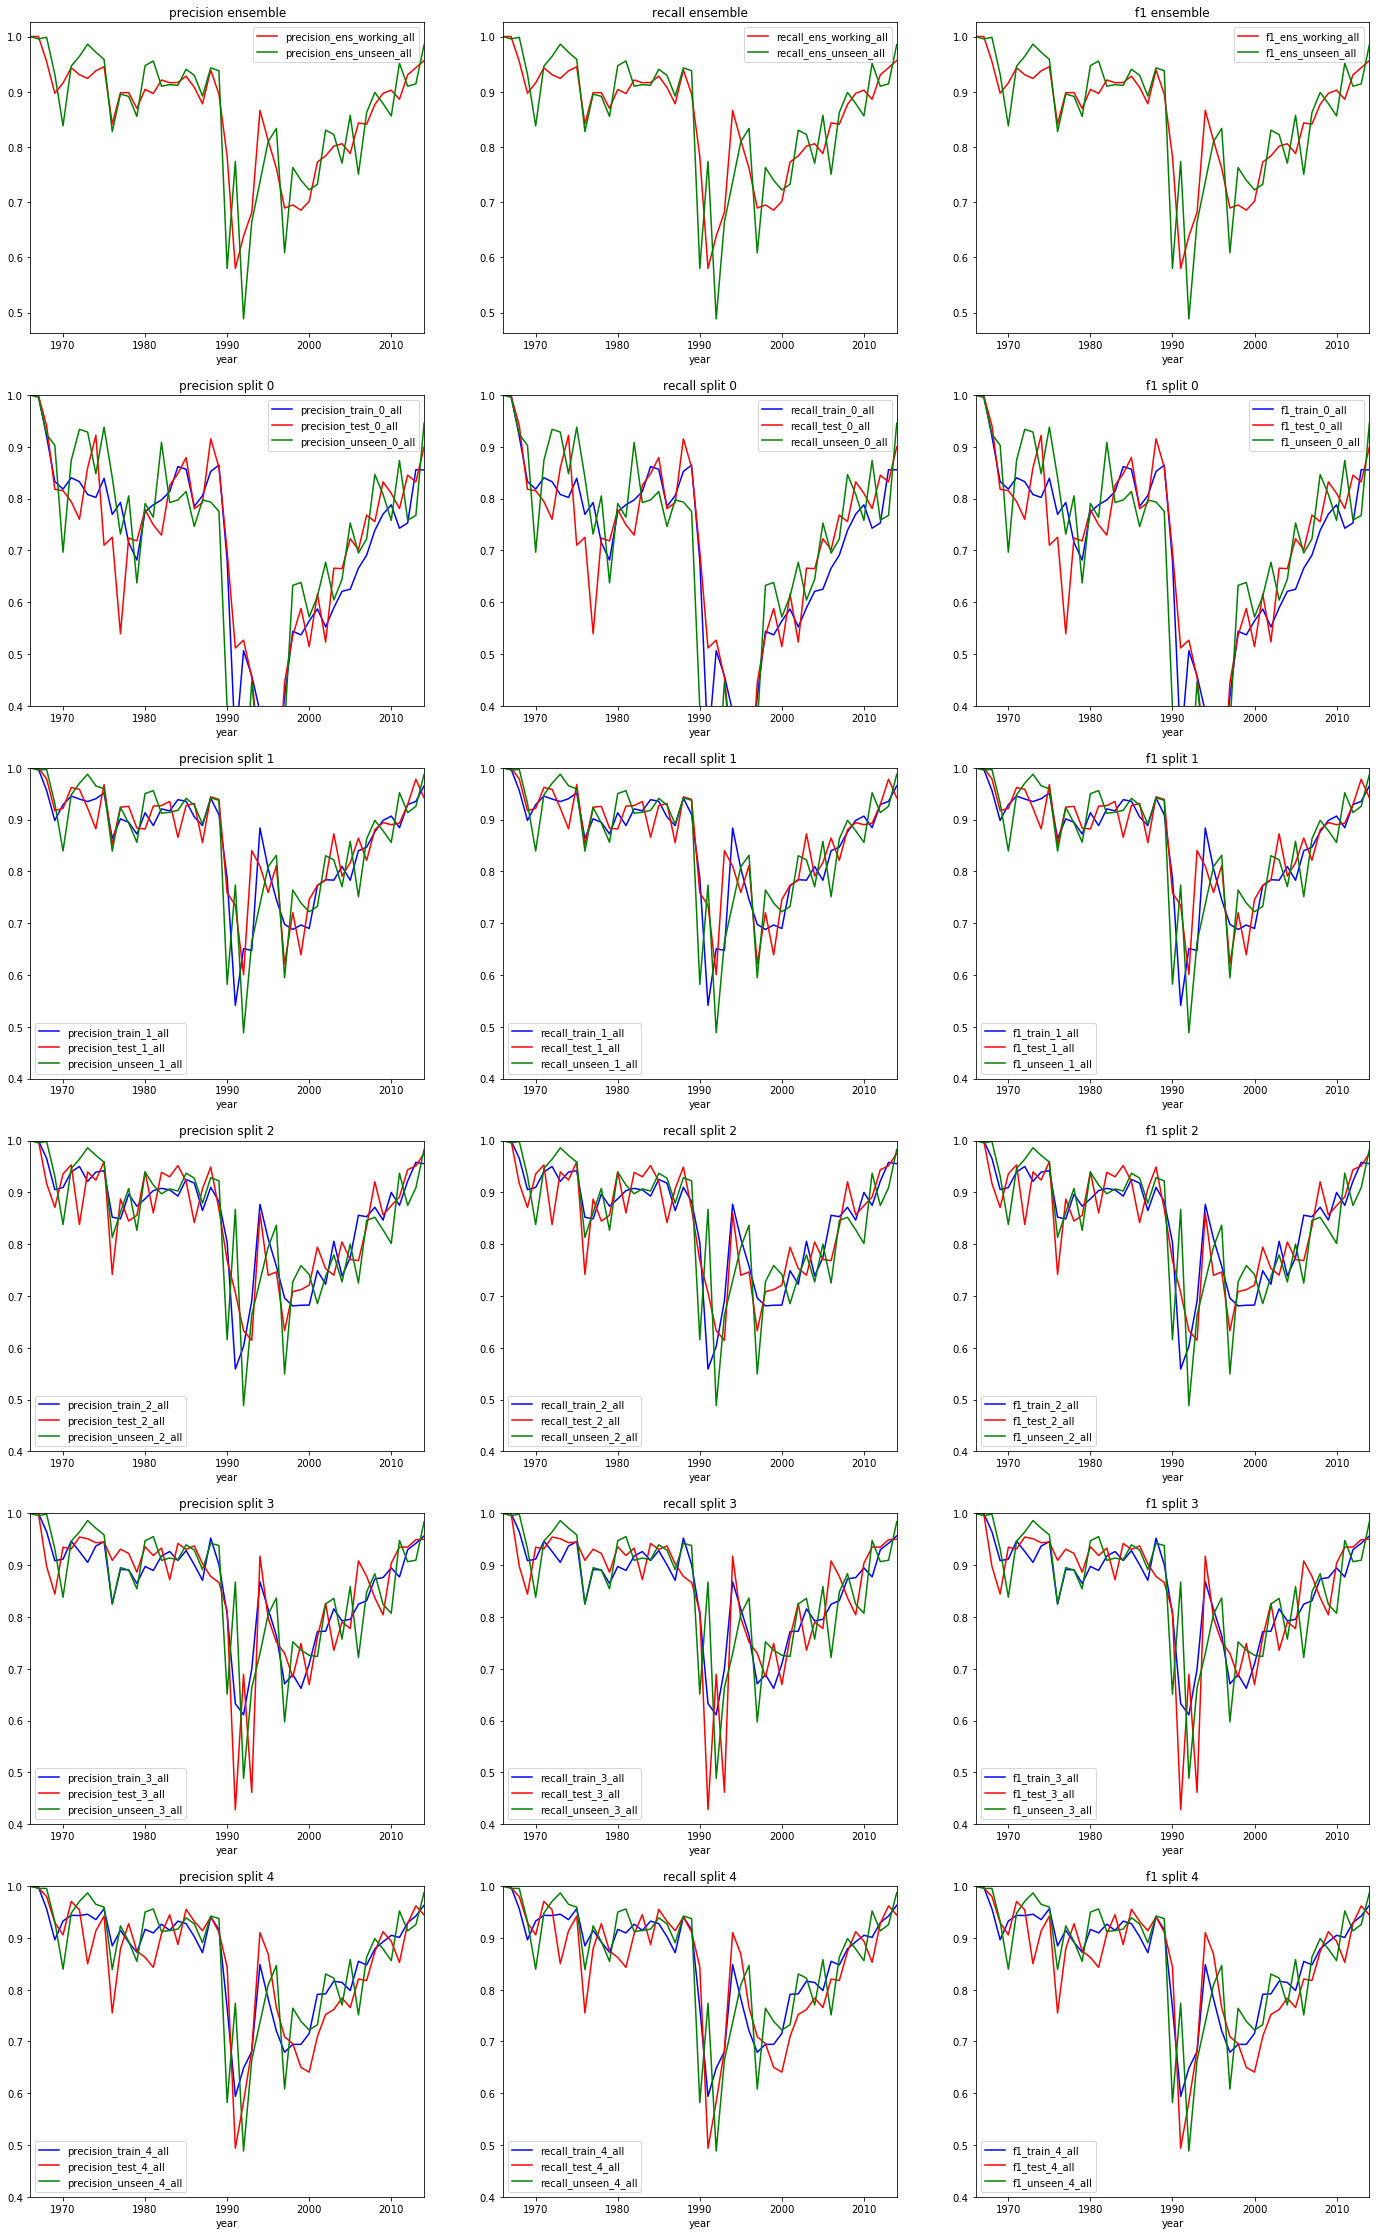

In [43]:
fig_results = matplotlib.pyplot.figure('xbt_results',figsize=(24,40))

ax_precision = fig_results.add_subplot(6,3,1, title='precision ensemble')
metrics_df_ens.plot.line(x='year',y=['precision_ens_working_all', 'precision_ens_unseen_all'], ax=ax_precision,color=['r','g'])
ax_recall = fig_results.add_subplot(6,3,2, title='recall ensemble')
metrics_df_ens.plot.line(x='year',y=['recall_ens_working_all', 'recall_ens_unseen_all'],ax=ax_recall,color=['r','g'])
ax_f1 = fig_results.add_subplot(6,3,3, title='f1 ensemble')
metrics_df_ens.plot.line(x='year',y=['f1_ens_working_all', 'f1_ens_unseen_all'],ax=ax_f1,color=['r','g'])

for label1, metrics1  in metrics_list.items():
    ax_precision = fig_results.add_subplot(6,3,label1*3 +4, title='precision split {0}'.format(label1))
    ax_recall = fig_results.add_subplot(6,3,label1*3 + 4 + 1, title='recall split {0}'.format(label1))
    ax_f1 = fig_results.add_subplot(6,3,label1*3 + 4 + 2, title='f1 split {0}'.format(label1))
    metrics1.plot.line(ax=ax_precision, x='year', y=[f'precision_train_{label1}_all',f'precision_test_{label1}_all', f'precision_unseen_{label1}_all' ], color=['b', 'r', 'g'], ylim=(0.4,1.0))
    metrics1.plot.line(ax=ax_recall, x='year', y=[f'recall_train_{label1}_all',f'recall_test_{label1}_all', f'recall_unseen_{label1}_all'], color=['b', 'r', 'g'], ylim=(0.4,1.0))
    metrics1.plot.line(ax=ax_f1, x='year', y=[f'f1_train_{label1}_all',f'f1_test_{label1}_all',f'f1_unseen_{label1}_all'], color=['b', 'r', 'g'], ylim=(0.4,1.0))

Also of interest is what hyper parameters were chosen by the GridCV hyperparameter tuning process. The following listing shows which parameters result in the best results for each split. We see that limiting the number of nodes resulted in better performance and restricting how nodes could split (min_samples_leaf) also varied based o the split. Varying these parameters results in different classifications so we get some profiles with different class assignments between different classifiers.

UPDATE: August 2020 - Currently we are finding a substantial degradation in terms of accuracy measured by recall for the hyperparameter tuning compared to just running the cross-validation. This may just be because there are more splits so the training set is smaller, but it may also be a bug in how this is being done. Further analysis is needed before we can use these results in a paper.

In [44]:
[est1.best_params_ for est1 in scores['estimator']]

[{'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1},
 {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1},
 {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1},
 {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1},
 {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1}]

In [45]:
metrics_df_merge = None
for label1, metrics1  in metrics_list.items():
    if metrics_df_merge is None:
        metrics_df_merge = metrics1
    else:
        metrics_df_merge = pandas.merge(metrics_df_merge, metrics1, on='year')

In [46]:
# merge in ensemble metrics
metrics_df_merge = pandas.merge(metrics_df_merge, metrics_df_ens, on='year')

In [53]:
results_output_path = os.path.join(xbt_output_dir,
                                   result_fname_template.format(classifier=classifier_name, 
                                                                suffix=suffix))
metrics_df_merge.to_csv(results_output_path)

### Outputting the data

To filter based on what profiles we can use for predicting, we need some way of checking each profile we create these checkers from the labelled dataset, because the subset of data that was used for training determines what subset is valid for prediction. For example, if a country is not present in the training data, then the prediction function won't be able to handle that profile to predict a probe model and manufacturer. Profiles that are not handled by the trained classifier will get the label "UNKNOWN".


In [ ]:
# checker functions check each element of the profile metadata that could be a problem. The checkers are constructed from the labelled data subset.
checkers_labelled = {f1: c1 for f1, c1 in xbt_labelled.get_checkers().items() if f1 in input_feature_names}

In [ ]:
%%time
xbt_predictable = xbt_full_dataset.filter_predictable(checkers_labelled)

In [ ]:
%%time
result_feature_names = []
# classifications_df = None
for split_num, estimator in enumerate(scores['estimator']):
    res_name = result_feature_template.format(split_num=split_num)
    result_feature_names += [res_name]
    res_ml1 = estimator.predict(xbt_predictable.filter_features(input_feature_names).get_ml_dataset()[0])
    res2 = list(xbt_labelled._feature_encoders[target_feature].inverse_transform(res_ml1).reshape(-1))
    xbt_predictable.xbt_df[res_name] = res2
    # Use the recorded instrument type where it exists (i.e. don't  overwrite with ML prediction)
    xbt_predictable.xbt_df.loc[xbt_labelled.xbt_df.index, res_name] = xbt_predictable.xbt_df.loc[xbt_labelled.xbt_df.index, target_feature]

In [ ]:
def imeta_instrument(row1):
    return 'XBT: {t1[0]} ({t1[1]})'.format(t1=imeta_classification(row1))

In [ ]:
%%time
imeta_output_flags = []
for res_name in result_feature_names:
    flag_name = f'imeta_applied_{res_name}'
    imeta_output_flags += [flag_name]
    xbt_predictable.xbt_df[flag_name] = 0
    xbt_predictable.xbt_df.loc[xbt_predictable.xbt_df[xbt_predictable.xbt_df[res_name].isnull()].index, flag_name] = 1
    xbt_predictable.xbt_df[flag_name] = xbt_predictable.xbt_df[flag_name].astype('int8')
    xbt_predictable.xbt_df.loc[xbt_predictable.xbt_df[xbt_predictable.xbt_df[res_name].isnull()].index, res_name] = \
        xbt_predictable.xbt_df[xbt_predictable.xbt_df[res_name].isnull()].apply(imeta_instrument, axis=1)



In [ ]:
%%time
fv_dict = {rfn1: UNKNOWN_STR for rfn1 in result_feature_names}
fv_dict.update({f1: 1 for f1 in imeta_output_flags})
xbt_full_dataset.merge_features(xbt_predictable, result_feature_names + imeta_output_flags,
                               fill_values = fv_dict,
                               feature_encoders={rfn1: xbt_labelled._feature_encoders[target_feature] for rfn1 in result_feature_names},
                               target_encoders={rfn1: xbt_labelled._target_encoders[target_feature] for rfn1 in result_feature_names},                                
                                output_formatters={rfn1: cat_output_formatter for rfn1 in result_feature_names})

In [ ]:
%%time
xbt_unknown_inputs = xbt_full_dataset.filter_obs({'classification_quality_flag': 0})
imeta_instrument_fallback = xbt_unknown_inputs.xbt_df.apply(imeta_instrument, axis=1)
for res_name in result_feature_names:
    xbt_full_dataset.xbt_df.loc[xbt_unknown_inputs.xbt_df.index, res_name] = imeta_instrument_fallback

The classifier is unable to predict a class for some of the profiles. This can be either because the classifier cannot produce a result, or because the country is not present in the labelled dataset. In these cases iMeta is used as a fallback. This plot shows for what proportion of profiles this occurs.

In [ ]:
pandas.DataFrame.from_records([dict(zip(['ML tree','imeta'] ,xbt_full_dataset.xbt_df[imf1].value_counts().values)) for imf1 in imeta_output_flags]).plot(kind='bar',stacked=True,title='Number of profiles falling back on iMeta', figsize=(12,12))

Of interest in our classifier ensemble is how many profiles are labelled differently by different classifiers. Here we count the different labels for each profile. We see  that the majority get only 1 label, but a substantial minority get 2 ior 3 labels, and some get as many as 5 (a different classification from each trained instance of the classifier!). For those profile which have been assigned more that one label, we can assign probabilities based on the number of classifiers "voting" for each label. This is not a real probability, but give some idea of the confidence we have in assigned labels. It could also be used as a distribution from which to sample for an esemble temperature dataset.

In [ ]:
%%time
count1 = xbt_full_dataset.filter_features(result_feature_names).xbt_df.apply(lambda row1: len(set(row1.values)), axis='columns')

In [ ]:
count1.value_counts()

In [ ]:
%%time
vote_count_full = numpy.zeros([xbt_full_dataset.shape[0], len(xbt_full_dataset._target_encoders[result_feature_names[0]].categories_[0])],dtype=numpy.float64)
for res_name in result_feature_names:
    vote_count_full += xbt_full_dataset.filter_features([res_name]).encode_target()[0]
    
vote_count_full /= float(len(result_feature_names))

In [ ]:
res_full_ensemble = vote_count_full.argmax(axis=1)
instr_res_full_ensemble = xbt_labelled._feature_encoders[target_feature].inverse_transform(res_full_ensemble)

In [ ]:
%%time
vote_dict = {f'instrument_probability_{cat1}': vote_count_full[:,ix1] for ix1, cat1 in enumerate(xbt_full_dataset._target_encoders[target_feature].categories_[0])}
vote_dict.update({'id': xbt_full_dataset['id'],
                  max_prob_feature_name: instr_res_full_ensemble
                 })
vote_df = pandas.DataFrame(vote_dict)

Note about cross validation: one can jkeeping doing forever, but we have limited data to test meaningfully each of our choices
what choices have we made?
what choices could we test further - future work!

In [ ]:
xbt_full_dataset.xbt_df = xbt_full_dataset.xbt_df.merge(vote_df, on='id')

In [ ]:
%%time
xbt_full_dataset.output_data(os.path.join(xbt_output_dir, output_fname_template.format(classifier=classifier_name,
                                                                                  suffix=suffix)),
                             target_features=[])

## Summary for ML tree with cross-validation and hyperparameter tuning

This notebook demonstrates a pipelines for training classifiers that includes the important steps of cross-validation and hyperparameter tuning. This will be what is ultimately used in training algorithms for producing instrument type classifications as part of the larger ocean temperature dataset production process.